# Sloan Digital Sky Survey Classification
## Classification of Galaxies, Stars and Quasars based on the RD14 from the SDSS

### About the notebook

In this notebook we will try to classify observations of space in three different categories: stars, galaxies, quasars.

We are using data from the Sloan Digital Sky Survey (**Release 14**). 

### About the SDSS

The Sloan Digital Sky Survey is a project which offers public data of space observations. 

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

**For more information about this awesome project - please visit their website:**

http://www.sdss.org/

![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

In [3]:
!pip install xgboost
!pip install s3fs

In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi'] = 150

## Data Acquisition

I you wish to find out more information about how to get data from the SDSS see their Data Access Guide:

http://www.sdss.org/dr14/data_access/

The query you can use to access the data is the following :

### Query

**SELECT TOP 10000** <br/>
p.objid, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z, p.run, p.rerun, p.camcol, p.field,  <br/>
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid  <br/>
**FROM** PhotoObj **AS** p <br/>
   **JOIN** SpecObj **AS** s **ON** s.bestobjid = p.objid <br/>
**WHERE** <br/>
   p.u **BETWEEN** 0 **AND** 19.6 <br/>
   **AND** g **BETWEEN** 0 **AND** 20 <br/>

The above query joins two tables (actually views): the image table (PhotoObj) which contains all image objects and the spectral table (SpecObj) which contains corresponding spectral data. 

### Feature Description

#### View "PhotoObj"
* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)

Right ascension (abbreviated RA) is the angular distance measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question. When paired with declination (abbreviated dec), these astronomical coordinates specify the direction of a point on the celestial sphere (traditionally called in English the skies or the sky) in the equatorial coordinate system.

Source: https://en.wikipedia.org/wiki/Right_ascension

* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further education: https://www.astro.umd.edu/~ssm/ASTR620/mags.html

* run = Run number
* rereun = Rerun number
* camcol = Camera column
* field = Field number

Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. A field can be identified by:
- **run** number, which identifies the specific scan,
- the camera column, or "**camcol**," a number from 1 to 6, identifying the scanline within the run, and
- the **field** number. The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
- An additional number, **rerun**, specifies how the image was processed. 

#### View "SpecObj"

* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)

The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID

In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

**Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php 

http://www.sdss3.org/dr8/glossary.php

You can load this project's data using the following link: ```s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/boosting_model_eval/Skyserver_SQL2_27_2018 6_51_39 PM.csv```

In [5]:
#load data)
sdss_df = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/boosting_model_eval/Skyserver_SQL2_27_2018 6_51_39 PM.csv', skiprows=0)

In [6]:
#explore data
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [7]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


The dataset has 10000 examples, 17 feature columns and 1 target column. 10 of the 17 features are 64 bit floats, 7 are 64 bit floats and the target column is of type object.

In [8]:
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [9]:
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [10]:
#convert columns to arrays
sdss_df.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

In [11]:
#drop unnecessary columns like identifiers and columns with camera info
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


### Univariate Analysis

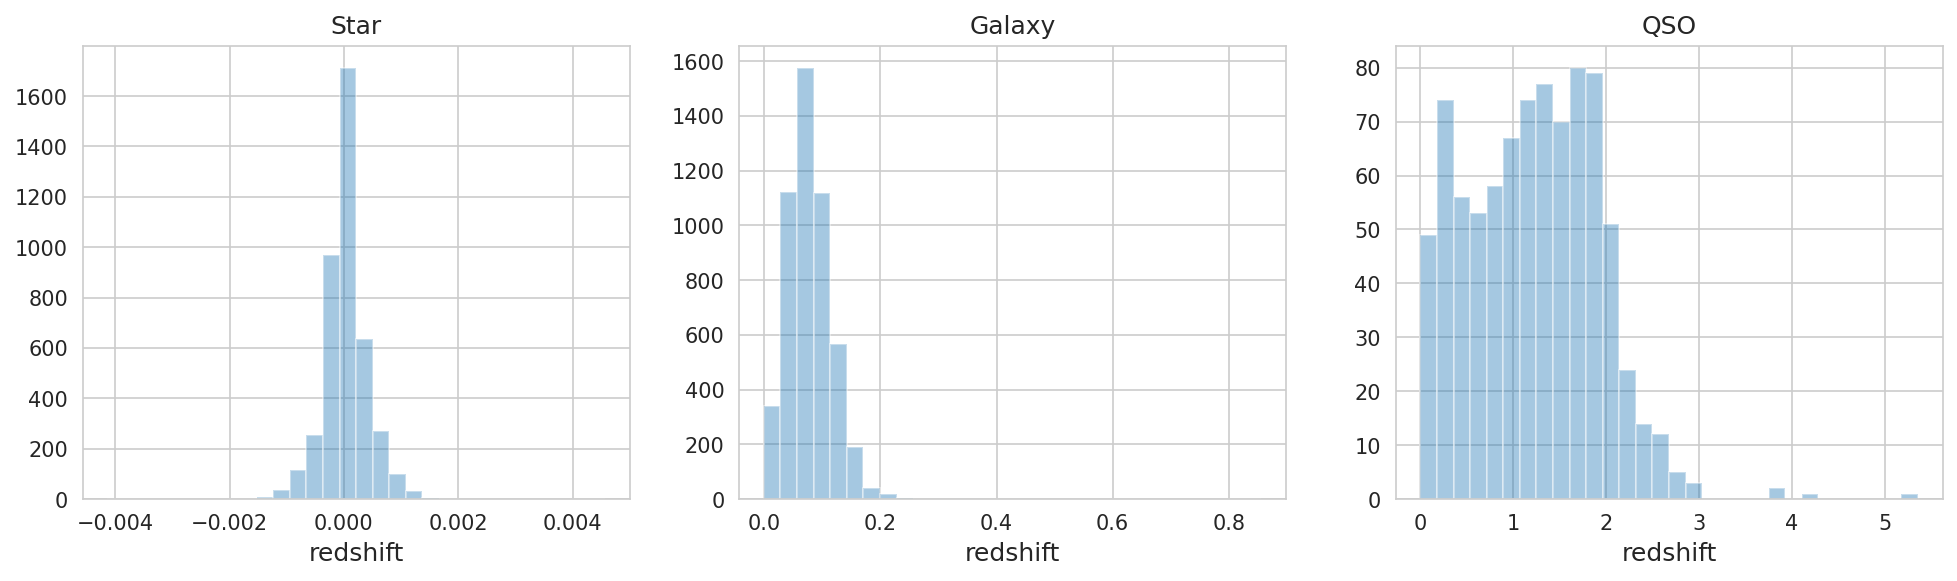

In [16]:
#start univariate analysis: plot redshift column per class
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins=30, ax=axes[0], kde=False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins=30, ax=axes[1], kde=False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins=30, ax=axes[2], kde=False)
ax = ax.set_title('QSO')

**The redshift can be an estimate(!) for the distance from the earth to a object in space.**

The distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.  

Possible rookie explanation: since galaxies and quasars radiate stronger due to their size and physical structure, they can be observed from further away than "small" stars.

As we can distinct the classes from each other just based on this column - 'redshift' is very likely to be helping a lot classifying new objects.

/Users/katie/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/katie/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/katie/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

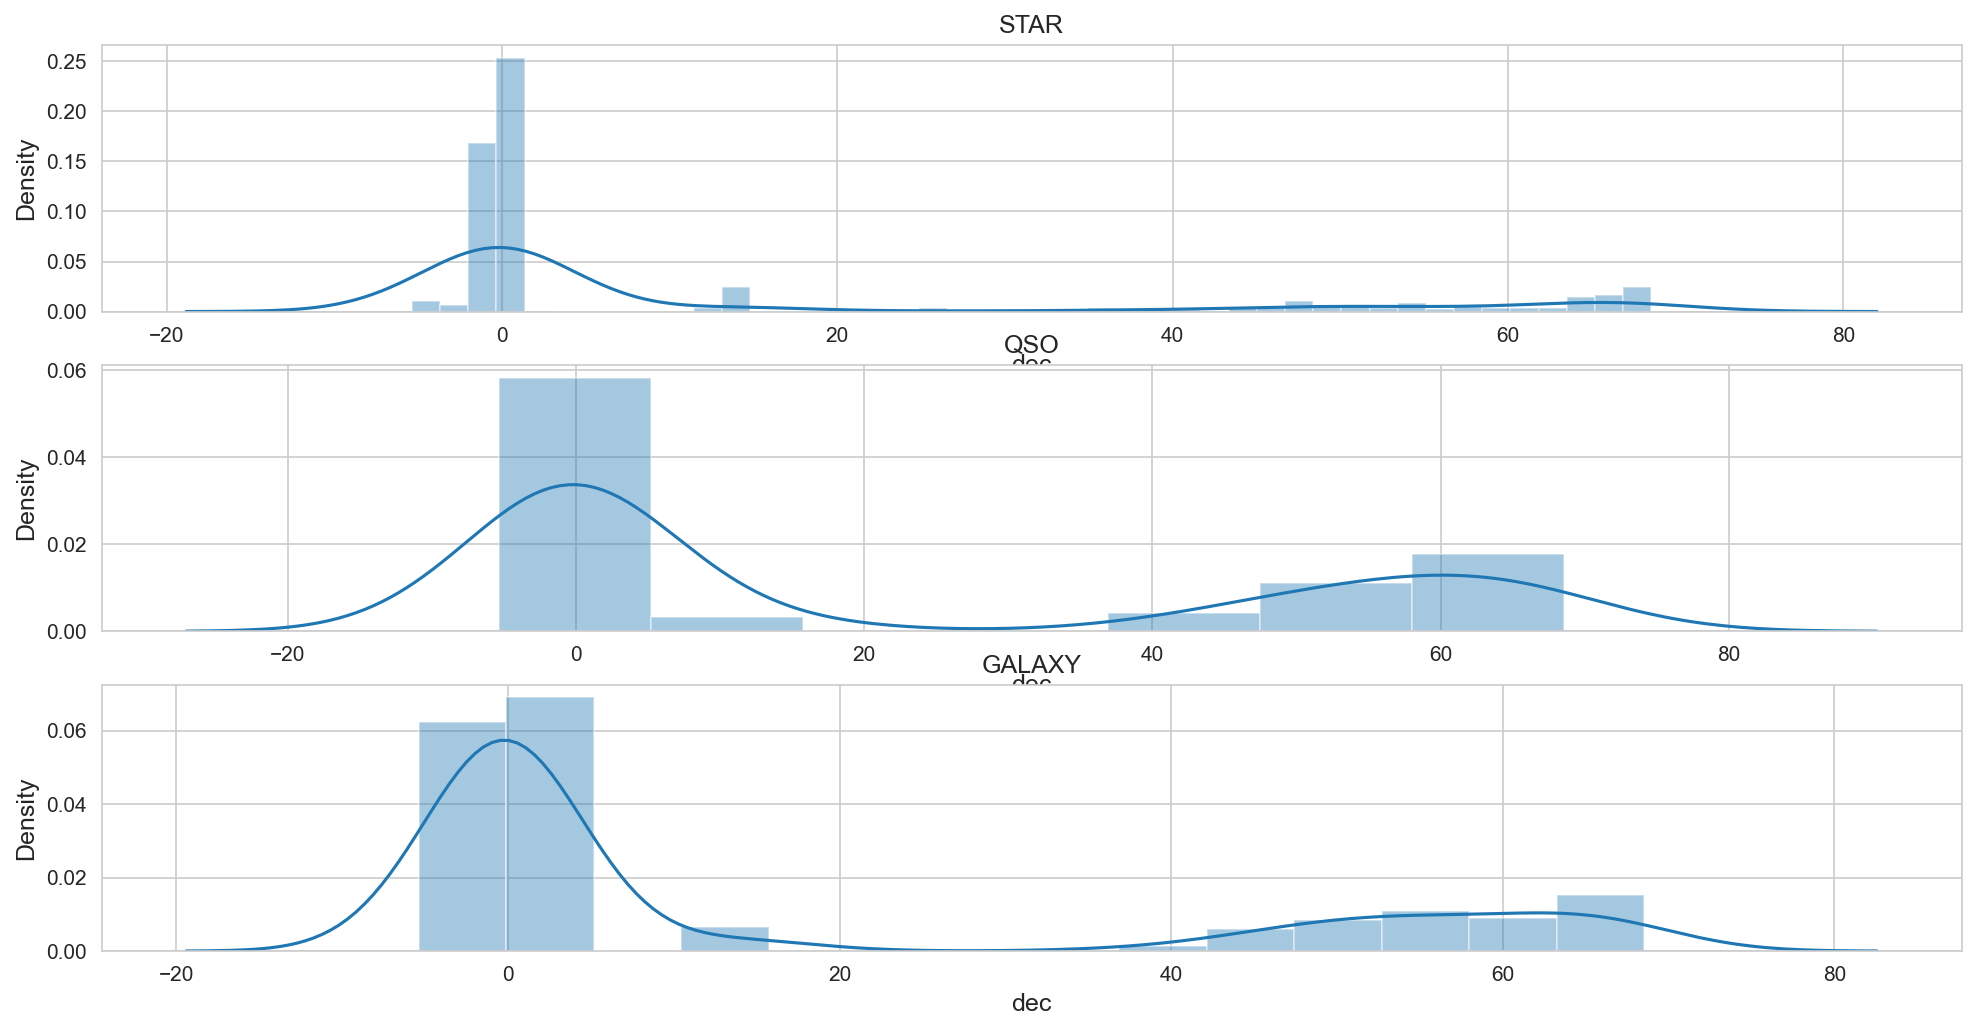

In [12]:
#plot dec (position on celestial equator)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 8))
for i, class_ in enumerate(set(sdss_df['class'])):
    sns.distplot(sdss_df.loc[sdss_df["class"]==class_, 'dec'], ax=axes[i])
    axes[i].set_title(class_)

Side Note: The fact that the distribution of dec values of galaxies and quasar objects is almost the same might indicate that one can find both galaxies and quasars at similar positions in the night sky.

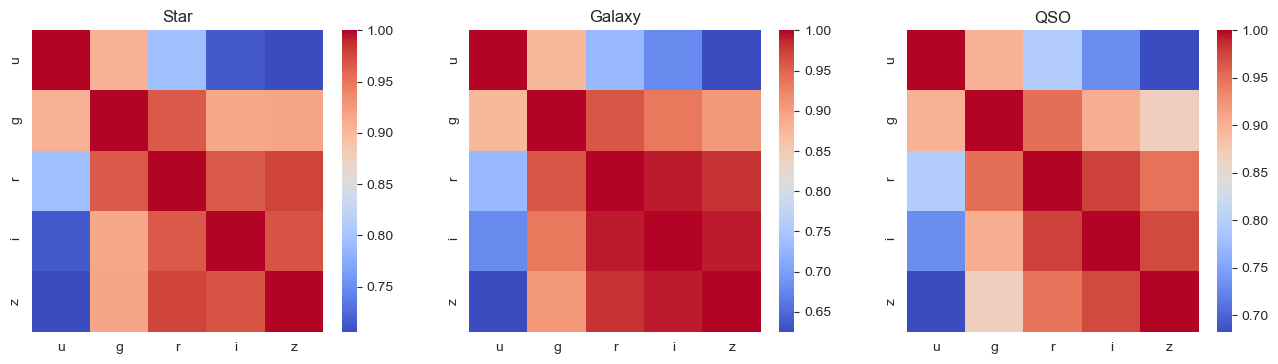

In [13]:
#start multicariate analysis: polor u, g, r, i, z (different wavelengths used to capture observations)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax=axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax=axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax=axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

The correlations are similar across the different categories, the different bands behave the same for the different classes!

Text(0.5, 1.0, 'Equatorial coordinates')

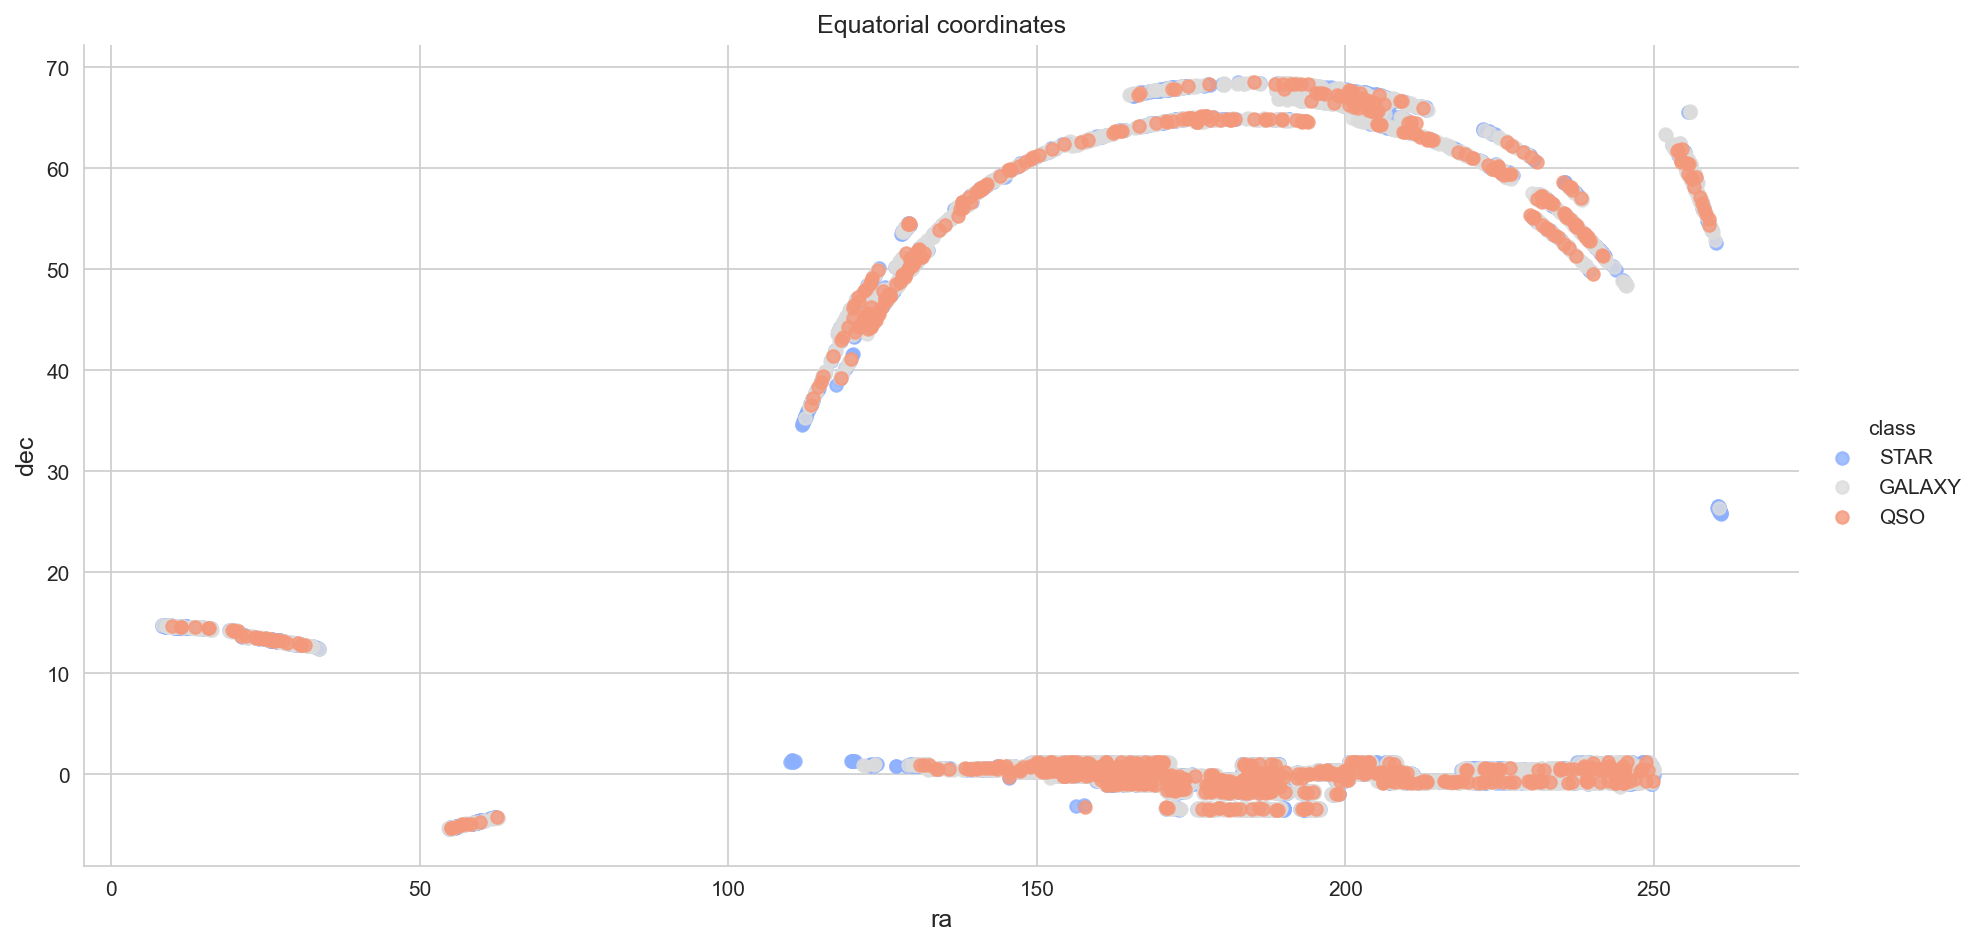

In [14]:
#plot right ascension vs declination by class
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', height=6, aspect=2)
plt.title('Equatorial coordinates')

The three different categories of space objects are not clusterised spatially.

All SDSS images cover the same area of the sky. The plot above tells us that stars, galaxies and quasars are observed equally at all coordinates within this area. So wherever the SDSS "looks" - the chance of observing a star or galaxy or quasar is always the same.

In [15]:
#do some feature engineering
sdss_df_fe = sdss_df

#encode categorical features as integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded
 
sdss_df_fe.head()

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512


In [16]:
#split data into train/test set
X_train, X_test, y_train, y_test = train_test_split(sdss_df.drop("class", axis=1), sdss_df_fe['class'], test_size=0.33)

In [17]:
#scale features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [19]:
#xgboost
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end - training_start
xgb_prediction_time = prediction_end - prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

AttributeError: dlsym(0x7fe1089efa10, XGDMatrixSetDenseInfo): symbol not found

In [21]:
#conduct k fold cross validation 
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring="accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [nan nan nan nan nan nan nan nan nan nan]
Mean: nan
Standard Deviation: nan


/Users/katie/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/katie/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/katie/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/katie/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py", line 422

In [22]:
#evaluate feature importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

AttributeError: Feature importance is not defined for Booster type None